<a href="https://colab.research.google.com/github/nelslindahlx/KnowledgeReduce/blob/main/CivicHonorsKGv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Overview

The revised code provides a complete and systematic workflow for web scraping, graph creation, and analysis in Google Colab, encompassing a range of functionalities from data extraction to advanced graph processing. Here's a summary of each step:

1. **Install Necessary Libraries**:
   - Installs essential Python packages such as `requests` for HTTP requests, `beautifulsoup4` for HTML parsing, `networkx` for graph operations, `lxml` for efficient HTML parsing, `matplotlib` for visualization, and `python-louvain` for community detection in graphs.

2. **Import Libraries**:
   - All necessary libraries are imported at once, setting up the environment for web scraping, graph creation, and analysis.

3. **Web Scraping**:
   - The script targets a specific URL and handles web requests with error management. The content of the webpage is fetched for further processing.

4. **Parse HTML Content**:
   - BeautifulSoup, with the 'lxml' parser, processes the HTML content of the webpage, preparing it for data extraction.

5. **Fact Extraction from Web Page**:
   - Implements logic to extract textual data (facts) from relevant HTML elements like paragraphs, articles, sections, and divs. This information is stored in a list.

6. **Graph Creation and Saving**:
   - A directed graph is created using NetworkX, where each unique fact extracted from the website forms a node. The graph is then saved in both GEXF and GraphML formats for subsequent use.

7. **Basic Graph Visualization**:
   - Visualizes a small part of the knowledge graph for initial inspection, using a spring layout for clearer node arrangement.

8. **Combine Multiple Graph Files**:
   - Introduces functions to read individual graph files in GEXF and GraphML formats and merge them into a single comprehensive graph. This step automates the detection and processing of multiple graph files.

9. **Advanced Graph Analysis**:
   - The final, merged graph undergoes advanced analysis, including integrity checks, a portion visualization, community detection using the Louvain method, and visualization of the community structure. The script includes error handling for the community detection process.

This complete script offers a robust solution for automated data extraction, knowledge graph creation, and advanced network analysis. It's ideal for diverse applications, including but not limited to, web content analysis, social network analysis, and other data-driven research projects. The workflow is modular and can be adapted or expanded based on specific project requirements.


# Step 1: Install Necessary Libraries

In [1]:
!pip install requests beautifulsoup4 networkx lxml matplotlib python-louvain
# Upgrade the community package. Step 9 had problems without the upgrade
!pip install --upgrade python-louvain

# Step 2: Import Libraries

In [2]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
import re
import os
# Import the community package correctly
from community import community_louvain

# Step 3: Define the URL and Send a Request with Error Handling

In [3]:
url = "https://www.civichonors.com"
try:
    response = requests.get(url)
    response.raise_for_status()
except requests.exceptions.RequestException as e:
    print(f"Error during requests to {url} : {e}")

# Step 4: Parse the HTML Content with Robust Parsing

In [4]:
soup = BeautifulSoup(response.content, 'lxml') if response else None

# Step 5: Enhanced Fact Extraction Logic

In [5]:
if soup:
    facts = []

    # Targeted Section Extraction
    target_selectors = ['.fact-content', '#main-facts', 'div.info-box']
    for selector in target_selectors:
        for element in soup.select(selector):
            text = ' '.join(element.stripped_strings)
            if text:
                facts.append(text)

    # Pattern-Based Extraction
    for tag in soup.find_all(['p', 'article', 'section', 'div']):
        if re.search(r'^(Fact:|Info:|Note:)', tag.text) or re.search(r'\d{4}', tag.text):
            text = ' '.join(tag.stripped_strings)
            if text:
                facts.append(text)

    # Redundancy and Irrelevance Filtering
    non_fact_selectors = ['.advertisement', '#comments', '.footer']
    for selector in non_fact_selectors:
        for element in soup.select(selector):
            text = ' '.join(element.stripped_strings)
            if text in facts:
                facts.remove(text)
else:
    facts = []

# Step 6: Create a Directed Graph with Unique Facts

In [6]:
G = nx.DiGraph()
for i, fact in enumerate(set(facts)):  # Using set() for uniqueness
    G.add_node(i, label=fact)

# Save the Graph in GEXF and GraphML Formats
nx.write_gexf(G, 'civic_honors_facts_graph.gexf')
nx.write_graphml(G, 'civic_honors_facts_graph.graphml')

# Step 7: Test the Knowledge Graphs

Nodes in GEXF graph: 73
Edges in GEXF graph: 0


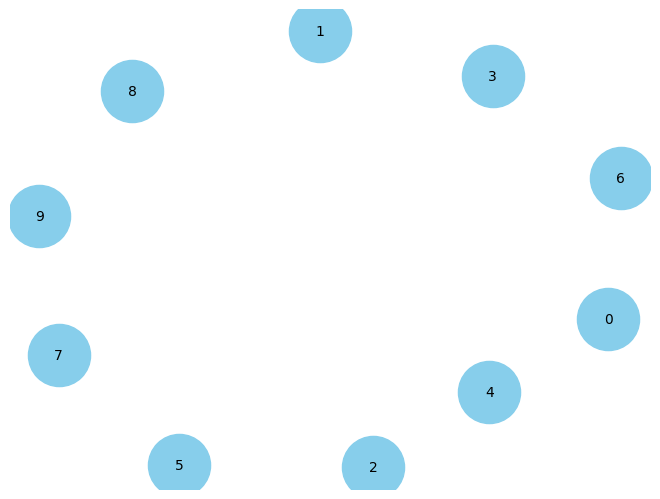

In [7]:
G_gexf = nx.read_gexf('civic_honors_facts_graph.gexf')
print("Nodes in GEXF graph:", len(G_gexf.nodes()))
print("Edges in GEXF graph:", len(G_gexf.edges()))

subgraph_nodes = list(G_gexf.nodes())[:10]
small_subgraph = nx.subgraph(G_gexf, subgraph_nodes)
pos = nx.spring_layout(small_subgraph)
nx.draw(small_subgraph, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10)
plt.show()

# Step 8: Handle and Combine Multiple Graph Files

In [8]:
def read_graph(file_path):
    if file_path.endswith('.gexf'):
        return nx.read_gexf(file_path)
    elif file_path.endswith('.graphml'):
        return nx.read_graphml(file_path)
    else:
        raise ValueError("Unsupported file format")

def merge_graphs(graphs):
    merged_graph = nx.DiGraph()
    for graph in graphs:
        merged_graph = nx.compose(merged_graph, graph)
    return merged_graph

graph_files = [f for f in os.listdir() if f.endswith('.gexf') or f.endswith('.graphml')]
all_graphs = [read_graph(file) for file in graph_files]
merged_graph = merge_graphs(all_graphs)
nx.write_gexf(merged_graph, 'merged_knowledge_graph.gexf')

# Step 9: Test and Evaluate the Merged Graph

Nodes in merged graph: 73
Edges in merged graph: 0


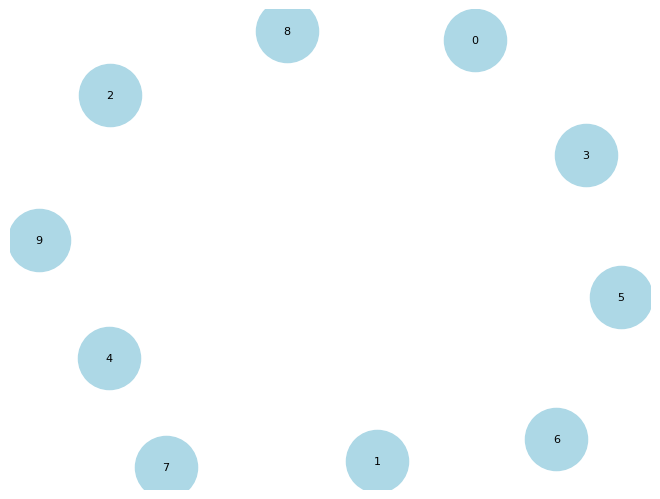

Number of communities detected: 73


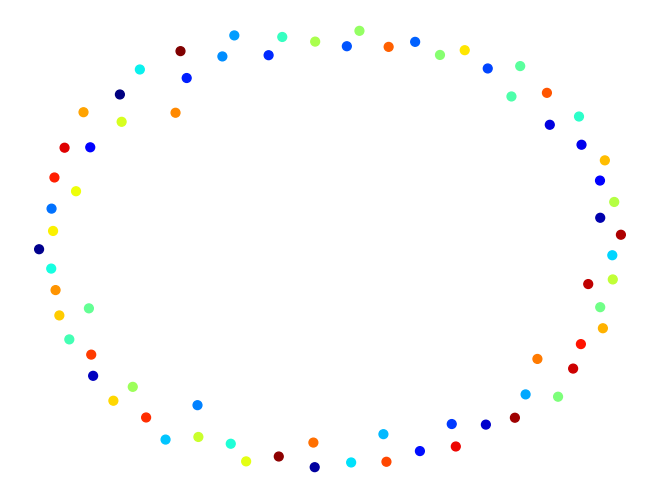

In [9]:
print("Nodes in merged graph:", len(merged_graph.nodes()))
print("Edges in merged graph:", len(merged_graph.edges()))

subgraph_nodes = list(merged_graph.nodes())[:10]
subgraph = nx.subgraph(merged_graph, subgraph_nodes)
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8)
plt.show()

try:
    partition = community_louvain.best_partition(merged_graph.to_undirected())
    num_communities = len(set(partition.values()))
    print("Number of communities detected:", num_communities)

    colors = [partition[node] for node in merged_graph.nodes()]
    nx.draw(merged_graph, node_color=colors, node_size=40, cmap=plt.cm.jet)
    plt.show()
except AttributeError as e:
    print("Error in community detection:", e)